In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
X = pd.read_csv("../data/processed/X_reduced.csv")
y = pd.read_csv("../data/processed/y.csv").squeeze()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=10
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (34935, 17)
X_test: (14973, 17)
y_train: (34935,)
y_test: (14973,)


In [6]:
# linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# test the model both train and test
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.9282143576916762
Test Score: 0.9280547230217837


In [7]:
# calculate intercept and coefficients
intercept = lr_model.intercept_
coefficients = lr_model.coef_
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 4824.300272127093
Coefficients: [11160.92646188  -676.44399066  -514.22981577 12557.01293645
  4810.35770228   168.64666183   -35.7192924     39.96512973
   -24.65292857  -935.76061134  3387.91145477  1599.36226775
   391.1713038    735.91227798  2234.8047119    155.9846743
   415.90397305]


In [11]:
# feature importance based on coefficients
coef_df = pd.DataFrame(coefficients, index=X_test.columns, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=True)


/tmp/ipykernel_63304/559273050.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")


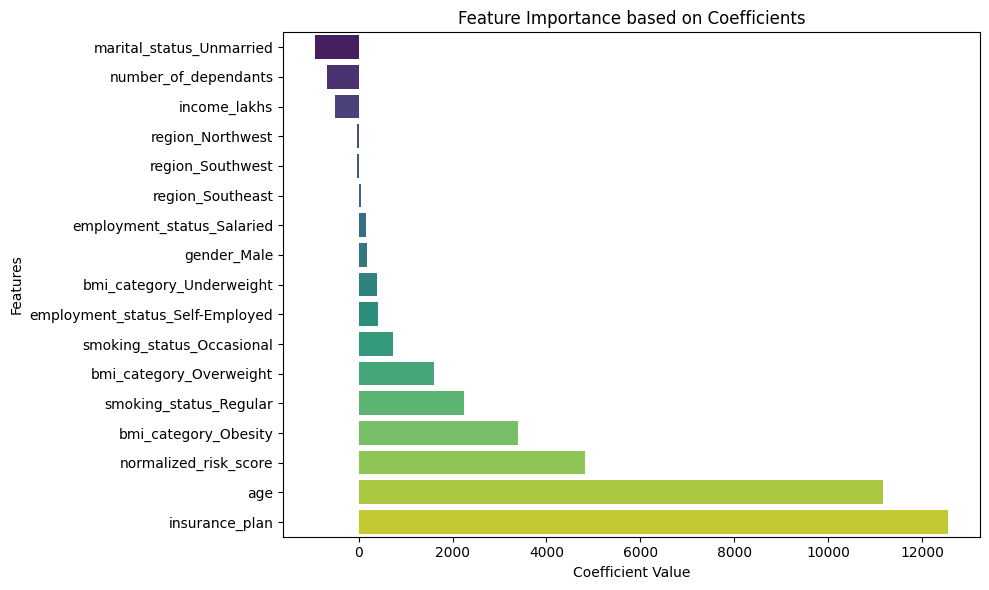

In [12]:
# create barh chart for coef_df
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")
plt.title("Feature Importance based on Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [14]:
# use XGboost for better performance (optional)
from xgboost import XGBRegressor

# train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# test the model both train and test
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

print(f"XGBoost Train Score: {xgb_train_score}")
print(f"XGBoost Test Score: {xgb_test_score}")

XGBoost Train Score: 0.9860964417457581
XGBoost Test Score: 0.9809534549713135


In [15]:
# grid search
param_grid = {
    'n_estimators': [20,40,50],
    'max_depth': [3,4,5],
    'learning_rate': [0.01, 0.1, 0.2]
}
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    random_state=42)

random_search.fit(X_train, y_train)
random_search.best_score_


np.float64(0.9809474547704061)

In [16]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

/tmp/ipykernel_63304/357034560.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")


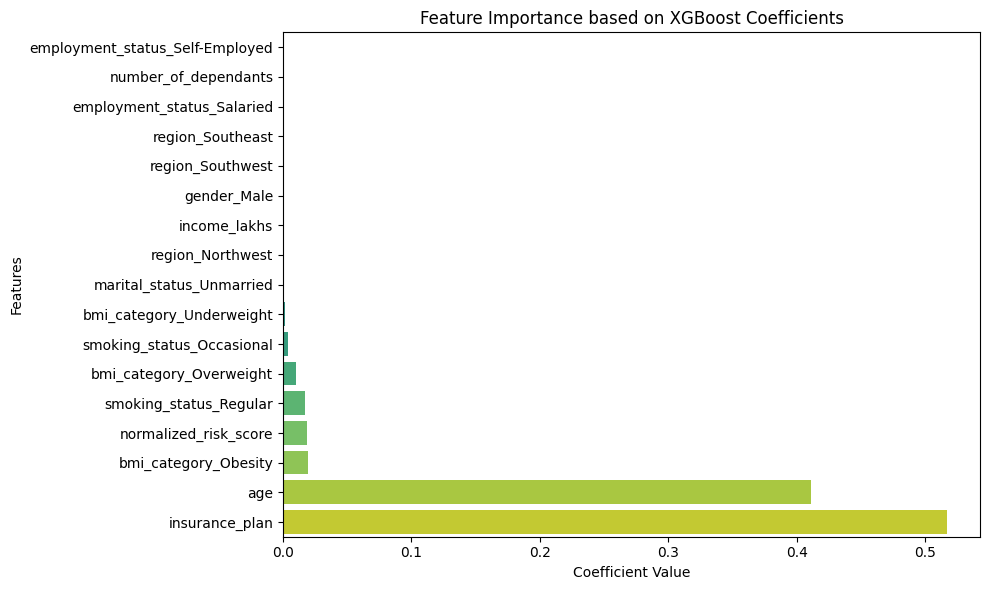

In [18]:
feature_importances = random_search.best_estimator_.feature_importances_

# feature importance based on coefficients
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=True)

# create barh chart for coef_df
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")
plt.title("Feature Importance based on XGBoost Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [20]:
best_model = random_search.best_estimator_

***Error Analysis**

In [21]:
y_pred = best_model.predict(X_test)

In [ ]:
# residuals and pct.
residuals =  y_pred - y_test
residuals_pct = residuals  * 100 / y_test

results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "diff": residuals,
    "diff_pct": residuals_pct
})

results_df.head()

,Actual,Predicted,diff,diff_pct
3589,20554,20334.953125,-219.046875,-1.065714
35724,29647,29378.779297,-268.220703,-0.904714
43526,20560,20618.185547,58.185547,0.283004
42648,5018,7352.829590,2334.829590,46.529087
18893,8929,8203.291992,-725.708008,-8.127540


In [23]:
# find extreame errors threshold 10%
extreme_results_df = results_df[np.abs(results_df["diff_pct"]) > 10]
extreme_results_df.shape

(4487, 4)

In [24]:
# pertange of error predictions
extreme_error_percentage = (extreme_results_df.shape[0] / results_df.shape[0]) * 100
extreme_error_percentage

29.967274427302478

In [25]:
X_test.index

Index([ 3589, 35724, 43526, 42648, 18893, 45330, 19984,  4282, 39069,  3143,
       ...
        4542,  9066,  8749,   601, 25123,  5609,  6055, 21545, 49183, 27919],
      dtype='int64', length=14973)

In [26]:
extreme_results_df.index

Index([42648, 19984,  4282, 44335,  6692, 11704, 15704, 34996,  9634, 22629,
       ...
       36088, 30325, 21137, 44935,  8232,  8749, 25123, 21545, 49183, 27919],
      dtype='int64', length=4487)

In [28]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42648,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
19984,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4282,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44335,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6692,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


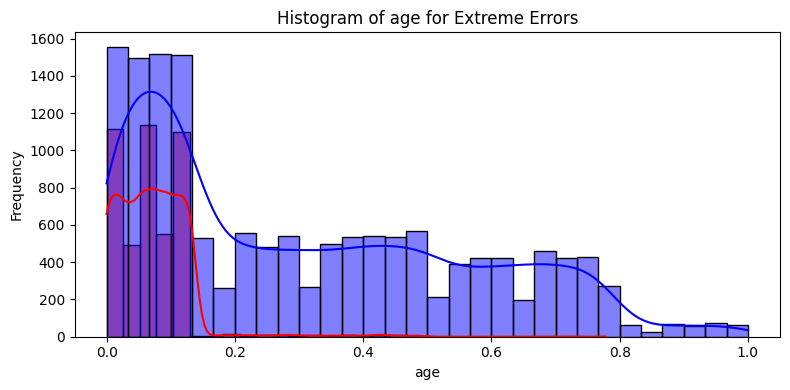

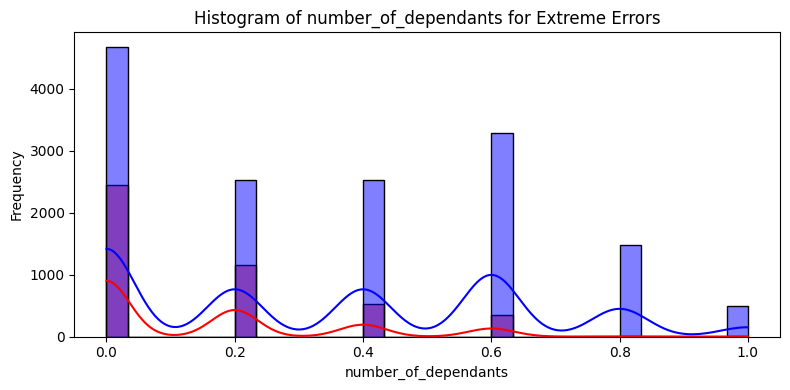

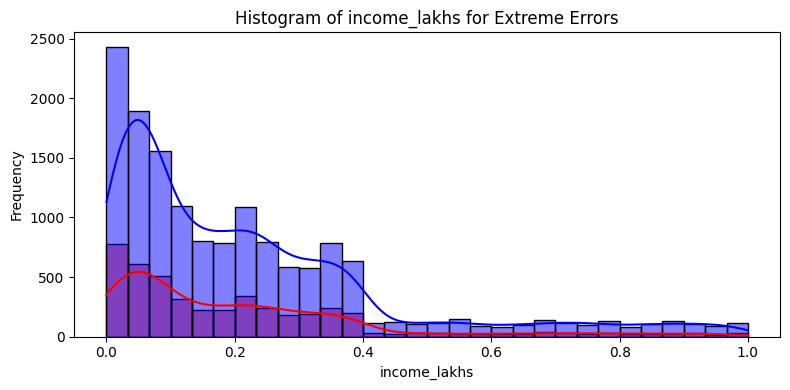

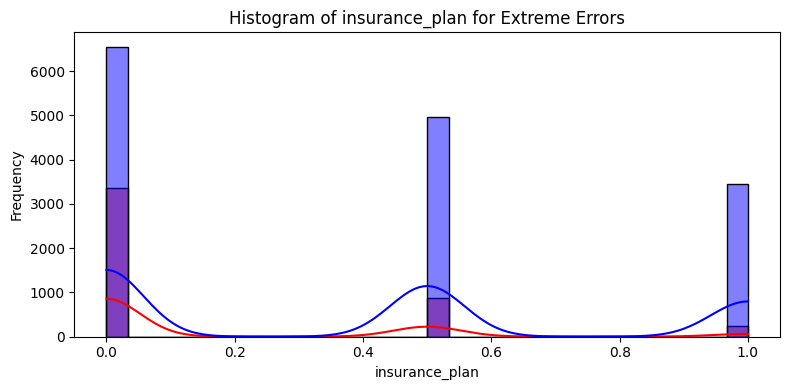

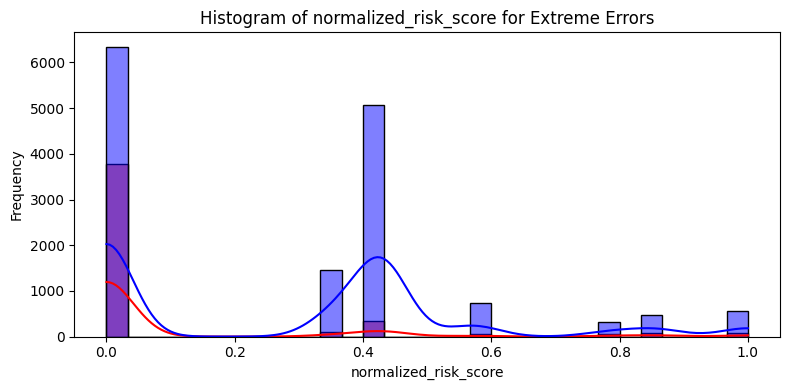

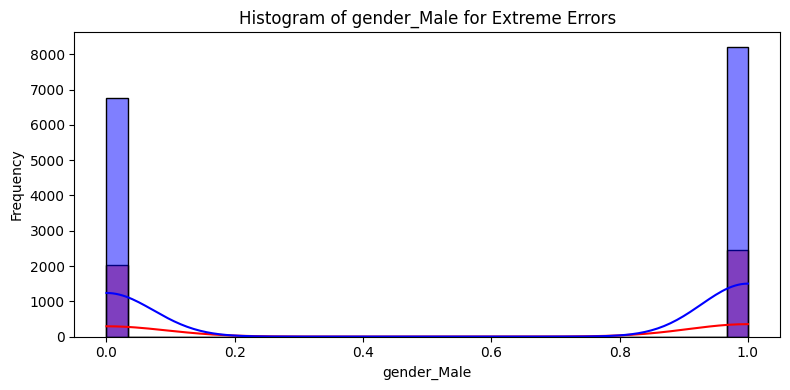

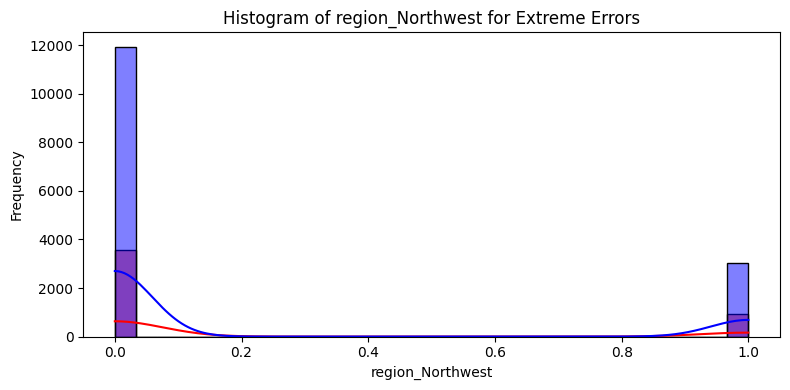

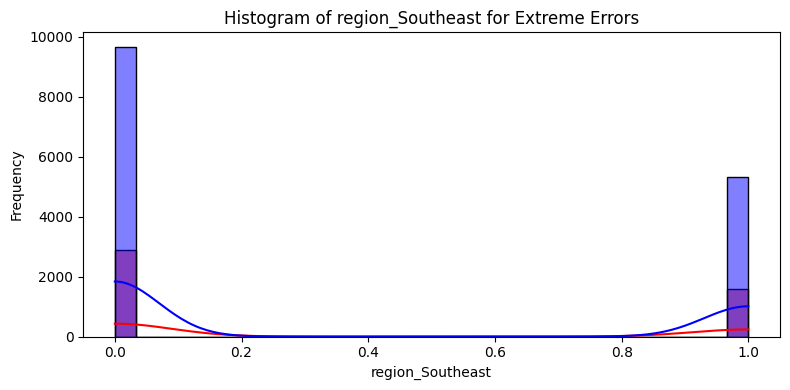

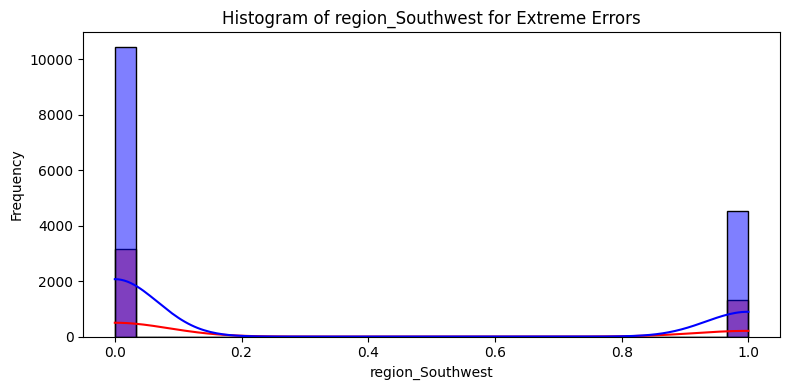

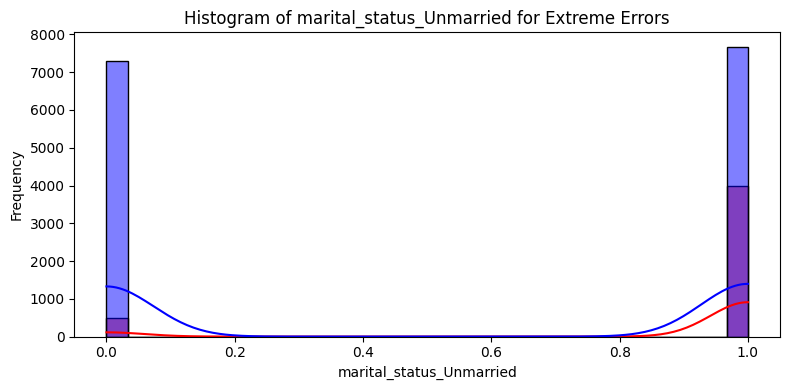

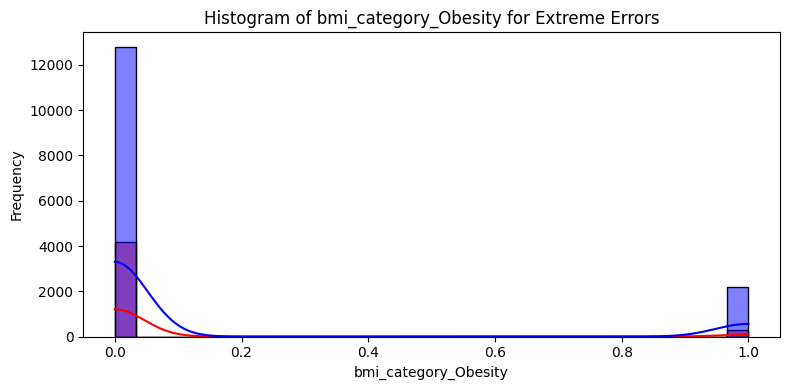

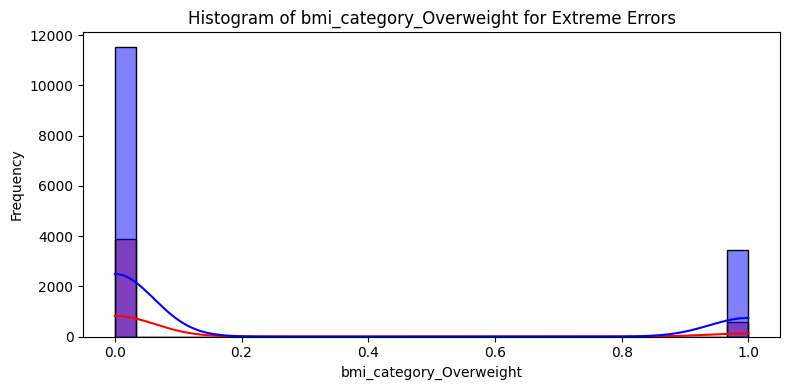

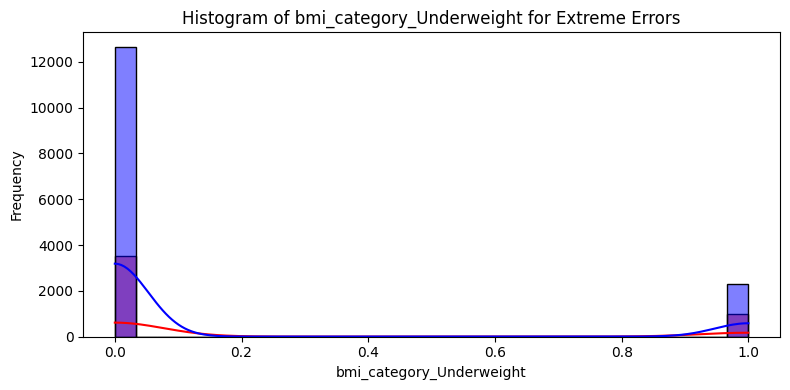

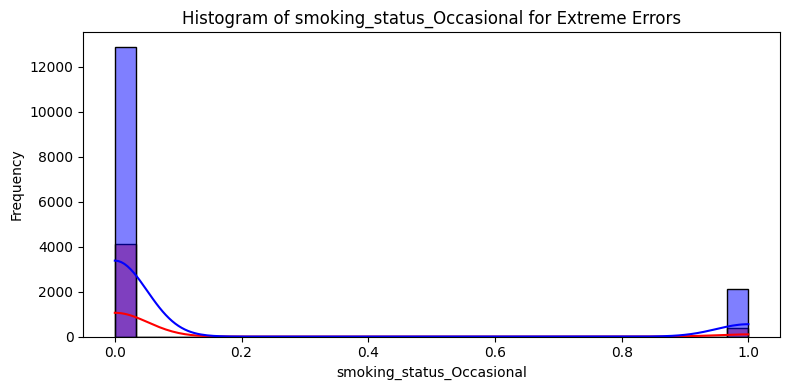

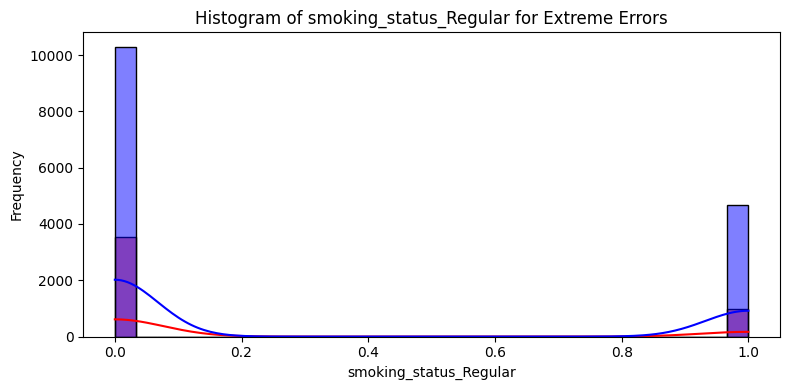

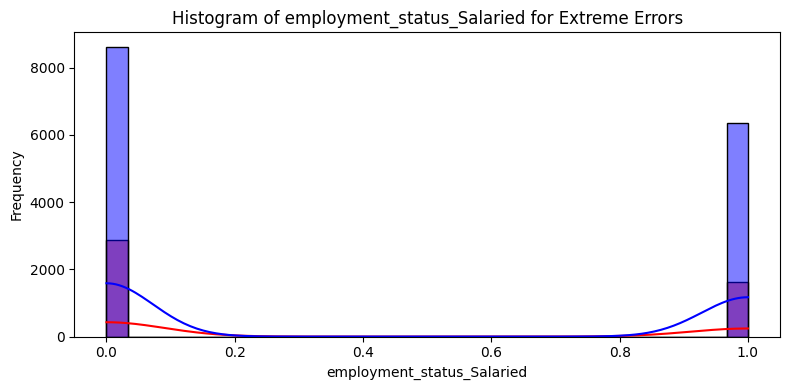

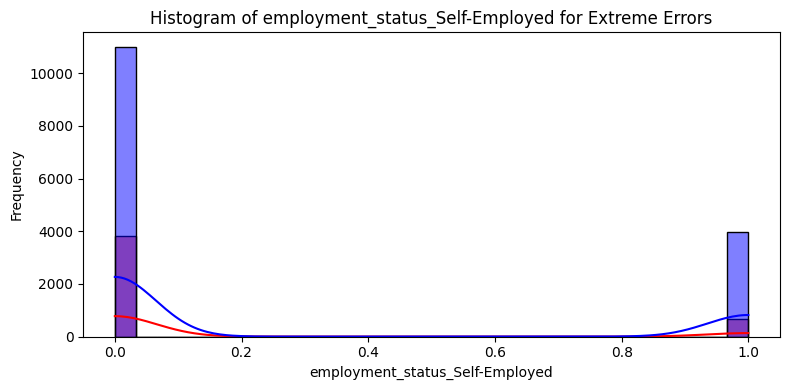

In [29]:
# print histogram of extreme error for features
for column in X_test.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(extreme_error_df[column], color='red', label = 'Extreme Errors', bins=30, kde=True)
    sns.histplot(X_test[column], color='blue', label = 'Overall', bins=30, kde=True, alpha=0.5)
    plt.title(f'Histogram of {column} for Extreme Errors')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [32]:
# Load processed data
df = pd.read_csv("../data/processed/df2_cleaned.csv")

<Axes: xlabel='age', ylabel='Count'>

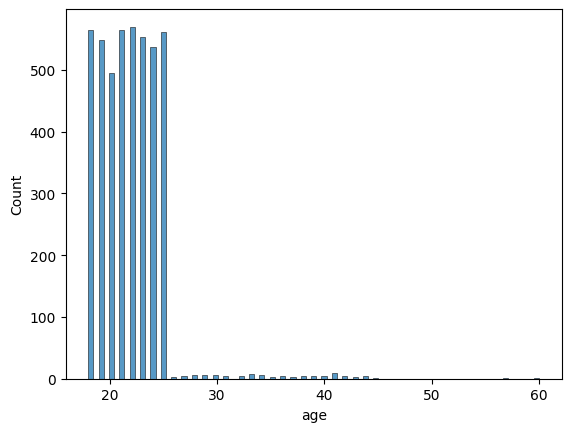

In [33]:
# align back to cleaned (unscaled) data
extreme_error_df = df.loc[extreme_results_df.index]
# now you have real age
sns.histplot(extreme_error_df['age'])